In [26]:
import pandas as pd
import texthero as hero
from nltk.corpus import stopwords
import umap
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.matutils import corpus2csc
import seaborn as sns
from scipy import stats

data_dir = "data/"

In [7]:
import tqdm
tqdm.tqdm.pandas()

# Load Data

In [ ]:
tweets_df = pd.read_json(data_dir + "german_covid.jsonl", lines=True)

In [ ]:
# users = pd.json_normalize(tweets_df["user"])
# users.info()

# Sentiment Analysis

In [4]:
from textblob_de import BlobberDE
blobber = BlobberDE()

In [5]:
def map_sentiment_textblob(text):
    tb = blobber(text)
    return tb.sentiment.polarity

In [6]:
impf = tweets_df[tweets_df["full_text"].str.lower().str.contains("impf")]  # impfstoff, impfung, impfen, ...
mask = tweets_df[tweets_df["full_text"].str.lower().str.contains("mask")]  # includes english stem as well
trac = tweets_df[tweets_df["full_text"].str.lower().str.contains("trac")]  # trace and track
len(impf), len(mask), len(trac)

(12260, 31856, 1385)

In [9]:
impf["sent_tb"] = impf["full_text"].progress_map(map_sentiment_textblob)
impf["sent_tb"].describe()

100%|██████████| 12260/12260 [02:13<00:00, 91.96it/s] 
<ipython-input-9-b11e96d92297>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impf["sent_tb"] = impf["full_text"].progress_map(map_sentiment_textblob)


count    12260.000000
mean         0.078077
std          0.410653
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.200000
max          1.000000
Name: sent_tb, dtype: float64

In [10]:
mask["sent_tb"] = mask["full_text"].progress_map(map_sentiment_textblob)
mask["sent_tb"].describe()

100%|██████████| 31856/31856 [05:49<00:00, 91.25it/s] 
<ipython-input-10-36ad8b16c2b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask["sent_tb"] = mask["full_text"].progress_map(map_sentiment_textblob)


count    31856.000000
mean         0.010009
std          0.341242
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: sent_tb, dtype: float64

In [11]:
trac["sent_tb"] = trac["full_text"].progress_map(map_sentiment_textblob)
trac["sent_tb"].describe()

100%|██████████| 1385/1385 [00:16<00:00, 81.69it/s]
<ipython-input-11-15aeba38a85d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trac["sent_tb"] = trac["full_text"].progress_map(map_sentiment_textblob)


count    1385.000000
mean        0.091513
std         0.326735
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.212500
max         1.000000
Name: sent_tb, dtype: float64

### Only keep tweets that express a sentiment

Objective statements might not represent a sentiment. Including those would not help the analysis, as it would dominate the dataset.
We use the assumption that the space is continous and thus remove just clearly non-sentiment (e.g., purely objective) tweets would not necesarily lead to a bimodal distribution.
Another way of looking at it is that we could also remove any particular value (e.g., 0.5) without altering the overall distribution. 
Note that things would change if we remove an interval instead (e.g., [-0.5, 0.5] would alwayls lead to a bimodal distribution, since no peak can emerge in the middle).

In [12]:
# Verify the assumption
impf["sent_tb"].value_counts(), mask["sent_tb"].value_counts(), trac["sent_tb"].value_counts()

( 0.000000    6840
  1.000000     965
 -0.700000     530
  0.350000     512
  0.700000     459
              ... 
  0.522222       1
 -0.071429       1
  0.558333       1
  0.544444       1
 -0.361111       1
 Name: sent_tb, Length: 257, dtype: int64,
  0.000000    16431
 -0.150000     1687
  0.350000     1087
 -0.500000      884
  1.000000      829
              ...  
 -0.025000        1
  0.094444        1
 -0.344444        1
 -0.131250        1
 -0.190000        1
 Name: sent_tb, Length: 490, dtype: int64,
  0.000000    751
  1.000000     57
  0.500000     50
  0.700000     48
  0.350000     44
             ... 
  0.050000      1
 -0.283333      1
  0.325000      1
 -0.616667      1
 -0.312500      1
 Name: sent_tb, Length: 114, dtype: int64)

# Calculating Statistics

In [13]:
impf_w = impf[impf["sent_tb"] != 0]
mask_w = mask[mask["sent_tb"] != 0]
trac_w = trac[trac["sent_tb"] != 0]
len(impf_w), len(mask_w), len(trac_w)

(5420, 15425, 634)

In [30]:
print("impf")
# print(stats.normaltest(impf_w['sent_tb'].values))
print(f"var:  {impf_w['sent_tb'].var()}")
print(f"skew: {impf_w['sent_tb'].skew()}")
print(f"kurt: {impf_w['sent_tb'].kurt()}")
impf_w["sent_tb"].describe()

impf
var:  0.3640867798081387
skew: -0.2745040757204821
kurt: -1.0242479232394304


count    5420.000000
mean        0.176610
std         0.603396
min        -1.000000
25%        -0.333333
50%         0.283333
75%         0.700000
max         1.000000
Name: sent_tb, dtype: float64

In [31]:
print("mask")
# print(stats.normaltest(mask_w['sent_tb'].values))
print(f"var:  {mask_w['sent_tb'].var()}")
print(f"skew: {mask_w['sent_tb'].skew()}")
print(f"kurt: {mask_w['sent_tb'].kurt()}")
mask_w["sent_tb"].describe()

mask
var:  0.240274186717451
skew: -0.06270836097748878
kurt: -0.399444232014428


count    15425.000000
mean         0.020671
std          0.490178
min         -1.000000
25%         -0.333333
50%         -0.050000
75%          0.350000
max          1.000000
Name: sent_tb, dtype: float64

In [32]:
print("trac")
# print(stats.normaltest(trac_w['sent_tb'].values))
print(f"var:  {trac_w['sent_tb'].var()}")
print(f"skew: {trac_w['sent_tb'].skew()}")
print(f"kurt: {trac_w['sent_tb'].kurt()}")
trac_w["sent_tb"].describe()

trac
var:  0.21170721179102275
skew: -0.19803013475403233
kurt: -0.3868433366696431


count    634.000000
mean       0.199915
std        0.460117
min       -1.000000
25%       -0.175000
50%        0.238095
75%        0.500000
max        1.000000
Name: sent_tb, dtype: float64

# Plotting

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette(sns.color_palette("blend:gray,white"))

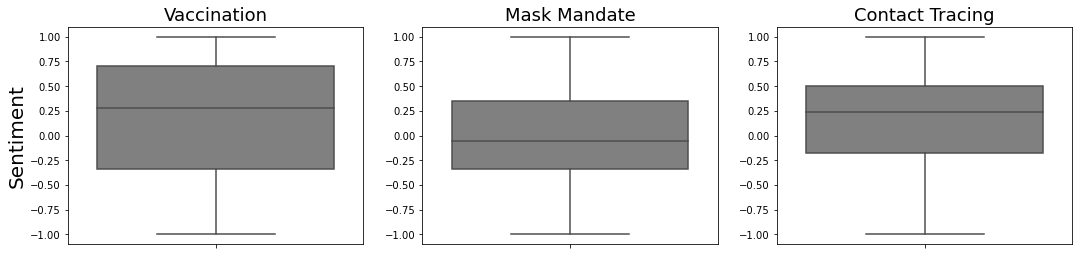

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
sns.boxplot(data=impf_w, y="sent_tb", ax=ax[0])
sns.boxplot(data=mask_w, y="sent_tb", ax=ax[1])
sns.boxplot(data=trac_w, y="sent_tb", ax=ax[2])
ax[0].set_title("impf")
ax[1].set_title("mask")
ax[2].set_title("trac");

ax[0].set_ylabel("Sentiment", fontsize=20)
ax[1].set_ylabel("")
ax[2].set_ylabel("")

ax[0].set_title("Vaccination", fontsize=18)
ax[1].set_title("Mask Mandate", fontsize=18)
ax[2].set_title("Contact Tracing", fontsize=18);

In [20]:
len(impf_w) + len(mask_w) + len(trac_w)

21479